In [125]:
# Import the libraries
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
# Initializing the parameters
vocab_size = 1000 # Max. no. of words to keep in the vocabulary
embedding_dim = 16 # Dimensionality of the word embeddings
max_length = 120 # Max. no. of tokens in a sentence
trunc_type='post' # Truncate extra words from the end of the sentence
padding_type='post' # Pad sentences with 0s at the end if shorter than max_length
oov_tok = "<OOV>" # Out-Of-Vocabulary token for unknown words
training_portion = .8 # Use 80% for training

In [127]:
# Initializing empty lists
sentences = []
labels = []

In [128]:
# Load stopwords
stop_words = set(stopwords.words('english'))

In [129]:
# Read CSV file
with open("/content/bbc-text.csv", 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # Skip header
  for row in reader:
    labels.append(row[0]) # Save first column in the labels list
    sentence = row[1] # Save second column in the sentences list

    # Remove stopwords from sentences
    for word in stop_words:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    sentences.append(sentence)

In [130]:
# Print to confirm data read correctly
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend  programmes content delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us tivo uk sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take europe lack high-definition programming. people forward wind adverts  also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite 

In [131]:
# Split data into training and validation sets
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Print lengths to verify splits
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [132]:
# Text Tokenization and Padding
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
# Dictionary mapping words to their index
word_index = tokenizer.word_index

# Convert training and validation sentences to sequences of word indices
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# Debug print to check a few padded sequences
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))


425
120
192
120
186
120


In [133]:
# Convert validation sentences to padded sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

# Debug print
print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [134]:
# Encode text labels to integers
label_tokenizer = Tokenizer()
# Fit on full label set to get consistent index mapping
label_tokenizer.fit_on_texts(labels)

# Convert label strings to sequences of integers, then convert to NumPy arrays
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# Debug print
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [135]:
# Initialize the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              input_shape=(max_length,)),
    tf.keras.layers.GlobalAveragePooling1D(), # Average the embedding vectors across all words
    tf.keras.layers.Dense(24, activation='relu'), # Hidden layer with ReLU
    tf.keras.layers.Dense(6, activation='softmax') # Output layer with 6 categories
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 120, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_24     │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,558 (64.68 KB)

 Trainable params: 16,558 (64.68 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# Train the model
# Initialize no. of epochs
num_epochs = 30

history = model.fit(
    train_padded,
    training_label_seq,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_label_seq),
    verbose=2
)

Epoch 1/30
56/56 - 2s - 36ms/step - accuracy: 0.2669 - loss: 1.7184 - val_accuracy: 0.4180 - val_loss: 1.6305
Epoch 2/30
56/56 - 1s - 16ms/step - accuracy: 0.4090 - loss: 1.5728 - val_accuracy: 0.4247 - val_loss: 1.5054
Epoch 3/30
56/56 - 0s - 6ms/step - accuracy: 0.4579 - loss: 1.4400 - val_accuracy: 0.4404 - val_loss: 1.3751
Epoch 4/30
56/56 - 1s - 10ms/step - accuracy: 0.5213 - loss: 1.2933 - val_accuracy: 0.6472 - val_loss: 1.2146
Epoch 5/30
56/56 - 0s - 5ms/step - accuracy: 0.6455 - loss: 1.1214 - val_accuracy: 0.8135 - val_loss: 1.0613
Epoch 6/30
56/56 - 0s - 6ms/step - accuracy: 0.8022 - loss: 0.9548 - val_accuracy: 0.8292 - val_loss: 0.9092
Epoch 7/30
56/56 - 1s - 11ms/step - accuracy: 0.8601 - loss: 0.8003 - val_accuracy: 0.8764 - val_loss: 0.7728
Epoch 8/30
56/56 - 0s - 5ms/step - accuracy: 0.8938 - loss: 0.6644 - val_accuracy: 0.8674 - val_loss: 0.6719
Epoch 9/30
56/56 - 1s - 11ms/step - accuracy: 0.9112 - loss: 0.5492 - val_accuracy: 0.8921 - val_loss: 0.5643
Epoch 10/30
56

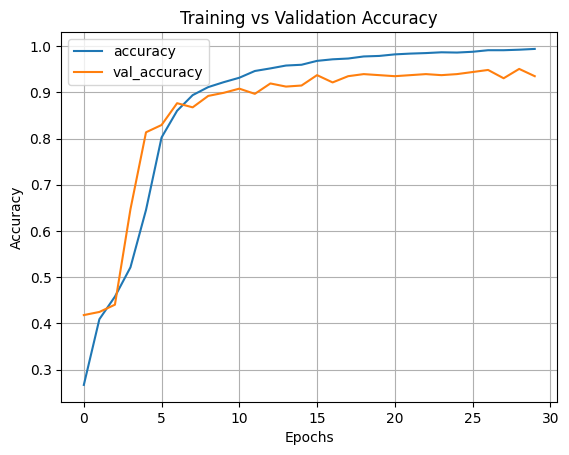

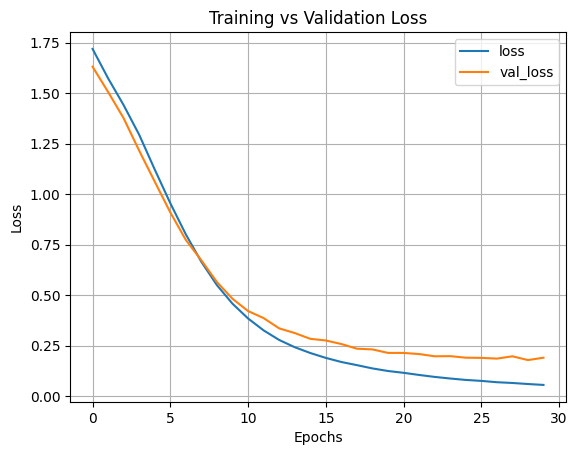

In [137]:
# Plot accuracy and loss graphs over epochs
def plot_graphs(history, metric_name):
  plt.plot(history.history[metric_name])
  plt.plot(history.history['val_' + metric_name])
  plt.xlabel("Epochs")
  plt.ylabel(metric_name.capitalize())
  plt.title(f"Training vs Validation {metric_name.capitalize()}")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.grid(True)
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")